#### **Assignment-3 Reinforcement learning programming**
Submitted by : Nikhil Shankar Chirakkal Sivasankaran
9026254

### **Google Colab Setup + Dependency Import**

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from collections import deque
from IPython import display
import gym

# For dependencies installation - with specific versions to avoid conflicts
!pip install numpy==1.26.0 # Use compatible numpy version
!pip install tensorflow
!pip install gym  # Using older gym version instead of gymnasium
!pip install gym[atari]
!pip install opencv-python
!pip install autorom
!pip install autorom[accept-rom-license]

import numpy as np
import gym  # Using older gym instead of gymnasium
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

#### **Provided Utils File**

In [41]:
import numpy as np

# This is specific to the pong environment
def img_crop(img):
    return img[30:-12,:,:]

# GENERAL Atari preprocessing steps
def downsample(img):
    # We will take only half of the image resolution
    return img[::2, ::2]

def transform_reward(reward):
    return np.sign(reward)

def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

# Normalize grayscale image from -1 to 1.
def normalize_grayscale(img):
    return (img - 128) / 128 - 1

def process_frame(img, image_shape):
    img = img_crop(img)
    img = downsample(img)    # Crop and downsize (by 2)
    img = to_grayscale(img)       # Convert to greyscale by averaging the RGB values
    img = normalize_grayscale(img)  # Normalize from -1 to 1.

    return np.expand_dims(img.reshape(image_shape[0], image_shape[1], 1), axis=0)

#### **Environment Hyperparameters**

In [ ]:
#Using Deterministic version of Pong
ENV_NAME = 'PongDeterministic-v4'
#Had to update the image size to (84,80) since encountered a shape mismatch error
IMAGE_SHAPE = (84, 80)  
#Stacking 4 frames together to reduce the training time.
STACK_SIZE = 4          

#Initial training will be run on batch size of 8, will run another round of training for 16 as well.
BATCH_SIZE = 8            
#Since running huge amount of episodes is not viable since colab is getting disconnected every 1 hour. 
#Using 10 episodes with frame wise split of updates. Every 1000 frames we will be updating/training the target model.
TARGET_UPDATE_FREQ = 1000    
GAMMA = 0.99 
MEMORY_SIZE = 10000         
TRAINING_START = 1000                 
EPSILON_DECAY = 0.995       
TRAINING_START = 10000      
LEARNING_RATE = 0.00025     
EPSILON_INIT = 1.0          
EPSILON_DECAY = 0.9995      
EPSILON_MIN = 0.05              

Using environment: PongDeterministic-v4


#### **Experience Replay Buffer**
- (state, action, reward, next_state, done)


In [43]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to the buffer"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from the buffer"""
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards, next_states, dones

    def size(self):
        """Return the current size of the buffer"""
        return len(self.buffer)

#### **Deep Q-Network CNN Architecture**
- Input : Convolutional layers
- Output : Q-Values
- Using Sequential CNN with three hidden layers.
- Using Mean Squared Error for training loss tracking
- Using Adam Optimizer for Learning rate

In [ ]:
def build_dqn(input_shape, n_actions):
    model = Sequential([
        # Convolutional Layers for game frame processing
        Conv2D(32, 8, strides=4, activation='relu', input_shape=input_shape),
        Conv2D(64, 4, strides=2, activation='relu'),
        Conv2D(64, 3, strides=1, activation='relu'),
        Flatten(),
        Dense(512, activation='relu'),
        #Q Value output
        Dense(n_actions, activation='linear') 
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mse')
    return model

#### **DQN-Agent**

In [ ]:
class DQNAgent:
    def __init__(self, state_shape, n_actions):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.epsilon = EPSILON_INIT

        #Defining Target and Main Models
        self.model = build_dqn(state_shape, n_actions)        
        self.target_model = build_dqn(state_shape, n_actions) 
        self.update_target()  

        #Declaring replay buffer created earlier
        self.memory = ReplayBuffer(MEMORY_SIZE)

        # Initialize trackers
        self.frame_count = 0
        self.episode_count = 0

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        # Exploration stage
        if np.random.rand() < self.epsilon:
            return random.randrange(self.n_actions)

        # Otherwise exploitation
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    
    def train(self):
      if self.memory.size() < TRAINING_START:
          self.frame_count += 1
          return 0 

      states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)


      states = states.reshape(BATCH_SIZE, self.state_shape[0], self.state_shape[1], self.state_shape[2])
      next_states = next_states.reshape(BATCH_SIZE, self.state_shape[0], self.state_shape[1], self.state_shape[2])


      next_q_values = self.target_model.predict(next_states, verbose=0)

      next_actions = np.argmax(self.model.predict(next_states, verbose=0), axis=1)
      max_next_q = next_q_values[np.arange(BATCH_SIZE), next_actions]

      targets = rewards + (1 - dones) * GAMMA * max_next_q

      current_q = self.model.predict(states, verbose=0)
      batch_indices = np.arange(BATCH_SIZE)
      current_q[batch_indices, actions] = targets

      loss = self.model.train_on_batch(states, current_q)

      if self.frame_count % 4 == 0 and self.epsilon > EPSILON_MIN:  
          self.epsilon = max(EPSILON_MIN, self.epsilon * EPSILON_DECAY)

      #Important : In the interest of time Keeping this to frame based update every 1000 frames.
      #In the assignment its asking for every 10 episode update, which will be done in the last part.
      if self.frame_count % TARGET_UPDATE_FREQ == 0:
          self.update_target()
          print(f"Updated target network at frame {self.frame_count}")

      self.frame_count += 1
      return loss

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

    def save_model(self, filepath):
        self.model.save(filepath)

    def load_model(self, filepath):
        self.model = tf.keras.models.load_model(filepath)
        self.update_target()

#### **Frame Processing Helper**
- To reduce processing time we combine multiple frames.

In [ ]:
class FrameStacker:
    def __init__(self, image_shape, stack_size):
        self.image_shape = image_shape
        self.stack_size = stack_size
        self.frames = np.zeros((1, image_shape[0], image_shape[1], stack_size))

    def reset(self, frame):
        processed_frame = process_frame(frame, self.image_shape)
        for i in range(self.stack_size):
            self.frames[0, :, :, i] = processed_frame[0, :, :, 0]
        return self.frames

    def add_frame(self, frame):
        processed_frame = process_frame(frame, self.image_shape)
        self.frames[0, :, :, :-1] = self.frames[0, :, :, 1:]
        self.frames[0, :, :, -1] = processed_frame[0, :, :, 0]
        return self.frames


#### **Model Training**

In [ ]:
def train_dqn(env_name, total_episodes=20, render=True, type="batch_8"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    import os
    save_path = '/content/drive/MyDrive/pong_dqn_models_' + type
    os.makedirs(save_path, exist_ok=True)

    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    print(f"Environment: {env_name}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    # Initialize the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)

    episode_rewards = []
    episode_losses = []

    # Import numpy here, inside the function's scope
    import numpy as np

    for episode in range(total_episodes):
        # Reset environment and get initial state (old gym API)
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        episode_loss = []
        done = False
        step = 0

        # Run one episode
        while not done:
            # Select action using epsilon-greedy policy
            action = agent.get_action(state)

            # Execute action in the environment
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Process reward (clip to -1, 0, 1 as per standard DQN implementation)
            processed_reward = transform_reward(reward)

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Store transition in replay buffer
            agent.store_transition(state, action, processed_reward, next_state, done)

            # Train agent
            loss = agent.train()
            if loss != 0:
                episode_loss.append(loss)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required (every 10 episodes to avoid slowing down training)
            if render and episode % 10 == 0:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        # Update target network according to update frequency
        agent.episode_count += 1
        if agent.episode_count % TARGET_UPDATE_FREQ == 0:
            agent.update_target()
            print(f"Updated target network at episode {agent.episode_count}")

        # Record metrics
        episode_rewards.append(episode_reward)
        if episode_loss:
            episode_losses.append(np.mean(episode_loss))
        else:
            episode_losses.append(0)

        # Print progress
        print(f"Episode {episode+1}/{total_episodes}, Steps: {step}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.4f}")

        # Save model every 3 episodes to Google Drive
        if (episode + 1) % 5 == 0:
            model_path = os.path.join(save_path, f"pong_dqn_episode_{episode+1}.keras")
            agent.save_model(model_path)
            print(f"Model saved at episode {episode+1} to {model_path}")

    # Save final model to Google Drive
    final_model_path = os.path.join(save_path, "pong_dqn_final.keras")
    agent.save_model(final_model_path)
    print(f"Final model saved to {final_model_path}!")

    # Also save the training metrics to Google Drive
    import numpy as np
    metrics_path = os.path.join(save_path, "training_metrics.npz")
    np.savez(metrics_path, rewards=episode_rewards, losses=episode_losses)
    print(f"Training metrics saved to {metrics_path}")

    env.close()

    return episode_rewards, episode_losses

## **Training With Batch Size - 8**
##### Updated every thousand frames
- Moving Average Calculated for Better Visualization


Mounted at /content/drive
Environment: PongDeterministic-v4
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)
Episode 1/10, Steps: 881, Reward: -21.0, Epsilon: 1.0000
Updated target network at frame 1000
Episode 2/10, Steps: 850, Reward: -21.0, Epsilon: 0.9125
Updated target network at frame 2000
Episode 3/10, Steps: 811, Reward: -21.0, Epsilon: 0.8244
Updated target network at frame 3000
Episode 4/10, Steps: 792, Reward: -21.0, Epsilon: 0.7467
Updated target network at frame 4000
Episode 5/10, Steps: 948, Reward: -19.0, Epsilon: 0.6633
Model saved at episode 5 to /content/drive/MyDrive/pong_dqn_models_batch_8/pong_dqn_episode_5.keras
Updated target network at frame 5000
Episode 6/10, Steps: 947, Reward: -20.0, Epsilon: 0.5891
Updated target network at frame 6000
Episode 7/10, Steps: 876, Reward: -21.0, Epsilon: 0.5280
Episode 8/10, Steps: 792, Reward: -21.0, Epsilon: 0.4782
Updated target network at frame 7000
Episode 9/10, Steps: 811, Reward: -21.0, Epsil

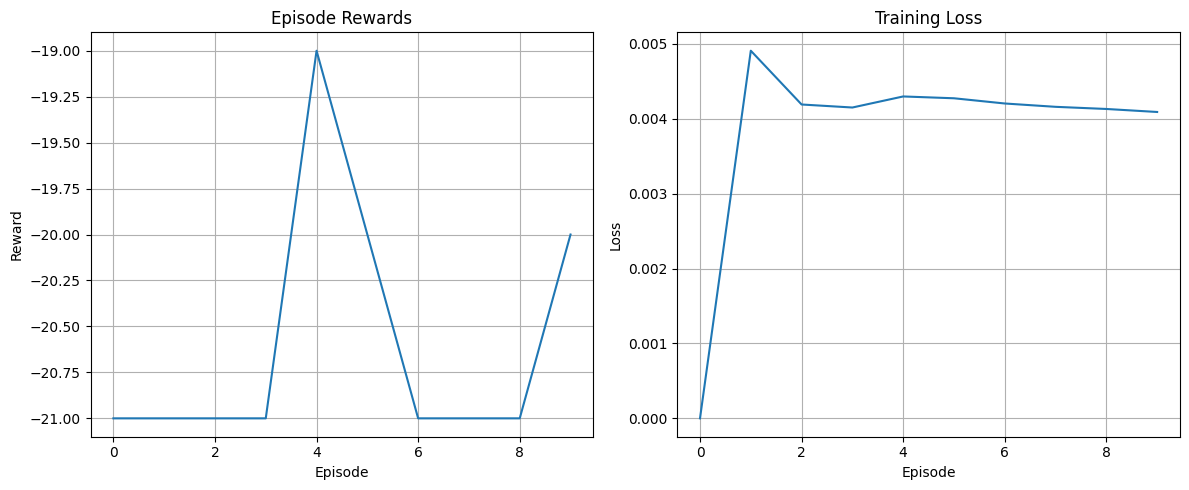

In [48]:
rewards, losses = train_dqn(ENV_NAME, total_episodes=10, render=False, type="batch_8")

## Visualize Training Results
"""
This code visualizes the training progress by plotting the rewards and losses.
"""
# Plot the rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

# Adding a moving average to see trends better
if len(rewards) > 10:
    moving_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(range(9, len(rewards)), moving_avg, 'r', label='10-episode moving average')
    plt.legend()

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')  # Save the figure
plt.show()

## **Evaluating Batch - 8**

In [54]:
import gym

def evaluate_agent(env_name, model_filename, n_episodes=5, render=True, type="batch_8"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)  # Don't force remount if already mounted

    # Construct path to the model file
    model_path = f'/content/drive/MyDrive/pong_dqn_models_{type}/{model_filename}'
    print(f"Loading model from: {model_path}")
    """Evaluate a trained DQN agent."""
    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    # Load the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)
    agent.load_model(model_path)
    # Use a small epsilon for some exploration during evaluation
    agent.epsilon = 0.05

    total_rewards = []

    for episode in range(n_episodes):
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        done = False
        step = 0

        while not done:
            # Select action
            action = agent.get_action(state)

            # Execute action
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required
            if render:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}/{n_episodes}, Steps: {step}, Reward: {episode_reward}")

    # Calculate statistics
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    print(f"Evaluation Results:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Min Reward: {np.min(total_rewards)}")
    print(f"Max Reward: {np.max(total_rewards)}")

    env.close()
    return total_rewards

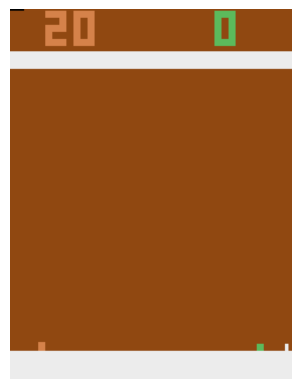

Evaluation Episode 5/5, Steps: 764, Reward: -21.0
Evaluation Results:
Average Reward: -20.80 ± 0.40
Min Reward: -21.0
Max Reward: -20.0
Average Evaluation Reward: -20.8


<Figure size 640x480 with 0 Axes>

In [ ]:
#Name of the saved model at the end of the training inside folder "batch_8"
evaluation_rewards = evaluate_agent(ENV_NAME, "pong_dqn_final.keras", n_episodes=5, type="batch_8")
print(f"Average Evaluation Reward: {np.mean(evaluation_rewards)}")

## **Training Batch Size - 16**
##### Updated every 1000 frames


Mounted at /content/drive
Environment: PongDeterministic-v4
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)
Updated target network at frame 1000
Episode 1/10, Steps: 1055, Reward: -20.0, Epsilon: 0.9986
Episode 2/10, Steps: 783, Reward: -21.0, Epsilon: 0.9792
Updated target network at frame 2000
Episode 3/10, Steps: 932, Reward: -20.0, Epsilon: 0.9567
Updated target network at frame 3000
Episode 4/10, Steps: 954, Reward: -21.0, Epsilon: 0.9342
Updated target network at frame 4000
Episode 5/10, Steps: 838, Reward: -20.0, Epsilon: 0.9148
Model saved at episode 5 to /content/drive/MyDrive/pong_dqn_models_batch_16/pong_dqn_episode_5.keras
Updated target network at frame 5000
Episode 6/10, Steps: 1105, Reward: -19.0, Epsilon: 0.8898
Updated target network at frame 6000
Episode 7/10, Steps: 903, Reward: -20.0, Epsilon: 0.8700
Updated target network at frame 7000
Episode 8/10, Steps: 856, Reward: -21.0, Epsilon: 0.8515
Updated target network at frame 8000
Episod

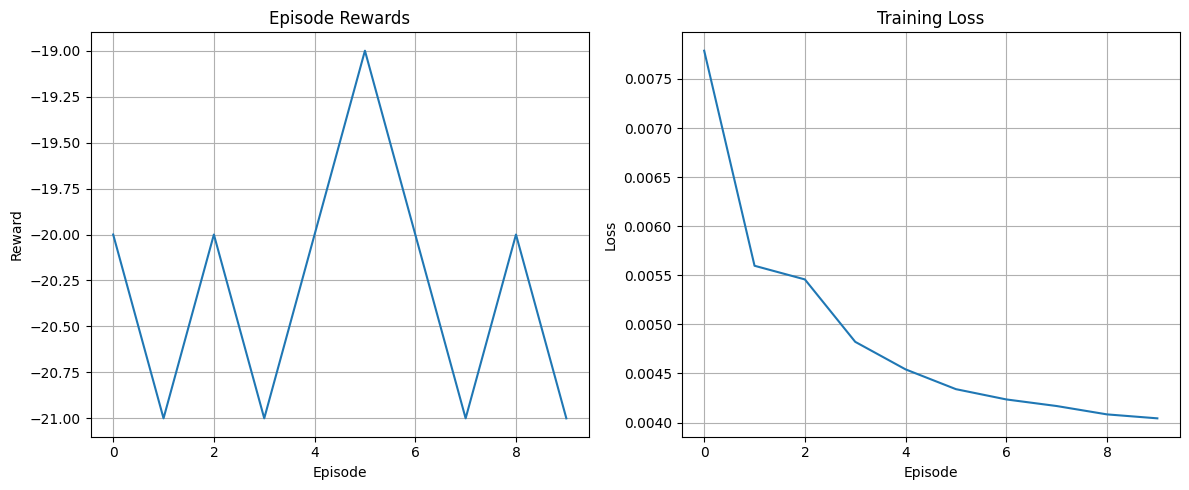

In [27]:
rewards, losses = train_dqn(ENV_NAME, total_episodes=10, render=False, type="batch_16")

## Visualize Training Results
"""
This code visualizes the training progress by plotting the rewards and losses.
"""
# Plot the rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

# Adding a moving average to see trends better
if len(rewards) > 10:
    moving_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(range(9, len(rewards)), moving_avg, 'r', label='10-episode moving average')
    plt.legend()

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')  # Save the figure
plt.show()

#### **Evaluation**

In [28]:
import gym

def evaluate_agent(env_name, model_filename, n_episodes=5, render=True, type="batch_16"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)  # Don't force remount if already mounted

    # Construct path to the model file
    model_path = f'/content/drive/MyDrive/pong_dqn_models_{type}/{model_filename}'
    print(f"Loading model from: {model_path}")
    """Evaluate a trained DQN agent."""
    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    # Load the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)
    agent.load_model(model_path)
    # Use a small epsilon for some exploration during evaluation
    agent.epsilon = 0.05

    total_rewards = []

    for episode in range(n_episodes):
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        done = False
        step = 0

        while not done:
            # Select action
            action = agent.get_action(state)

            # Execute action
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required
            if render:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}/{n_episodes}, Steps: {step}, Reward: {episode_reward}")

    # Calculate statistics
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    print(f"Evaluation Results:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Min Reward: {np.min(total_rewards)}")
    print(f"Max Reward: {np.max(total_rewards)}")

    env.close()
    return total_rewards

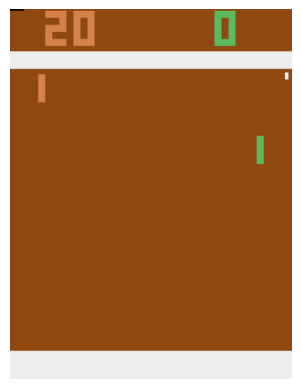

Evaluation Episode 5/5, Steps: 824, Reward: -21.0
Evaluation Results:
Average Reward: -21.00 ± 0.00
Min Reward: -21.0
Max Reward: -21.0
Average Evaluation Reward: -21.0


<Figure size 640x480 with 0 Axes>

In [ ]:
#Using the trained model saved in drive in another folder for batch_16
evaluation_rewards = evaluate_agent(ENV_NAME, "pong_dqn_final.keras", n_episodes=5, type="batch_16")
print(f"Average Evaluation Reward: {np.mean(evaluation_rewards)}")

## **Training Batch-16, Update every 500 frames**
- Previously we updated every 1000 frames

In [ ]:
#Using Deterministic version of Pong
ENV_NAME = 'PongDeterministic-v4'
#Had to update the image size to (84,80) since encountered a shape mismatch error
IMAGE_SHAPE = (84, 80)  
#Stacking 4 frames together to reduce the training time.
STACK_SIZE = 4          

#Initial training will be run on batch size of 8, will run another round of training for 16 as well.
BATCH_SIZE = 8            


#Important Change is here. Earlier we updated every 1000 frames, now we are doing it for every 500 frames.
TARGET_UPDATE_FREQ = 500   

GAMMA = 0.99 
MEMORY_SIZE = 10000         
TRAINING_START = 1000                 
EPSILON_DECAY = 0.995       
TRAINING_START = 10000      
LEARNING_RATE = 0.00025     
EPSILON_INIT = 1.0          
EPSILON_DECAY = 0.9995      
EPSILON_MIN = 0.05    

Mounted at /content/drive
Environment: PongDeterministic-v4
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(6)
Episode 1/10, Steps: 843, Reward: -21.0, Epsilon: 1.0000
Updated target network at frame 1000
Updated target network at frame 1500
Episode 2/10, Steps: 764, Reward: -21.0, Epsilon: 0.4668
Updated target network at frame 2000
Episode 3/10, Steps: 764, Reward: -21.0, Epsilon: 0.1792
Updated target network at frame 2500
Updated target network at frame 3000
Episode 4/10, Steps: 882, Reward: -21.0, Epsilon: 0.0592
Updated target network at frame 3500
Updated target network at frame 4000
Episode 5/10, Steps: 764, Reward: -21.0, Epsilon: 0.0500
Model saved at episode 5 to /content/drive/MyDrive/pong_dqn_models_batch_16/pong_dqn_episode_5.keras
Updated target network at frame 4500
Episode 6/10, Steps: 764, Reward: -21.0, Epsilon: 0.0500
Updated target network at frame 5000
Updated target network at frame 5500
Episode 7/10, Steps: 764, Reward: -21.0, Epsilon

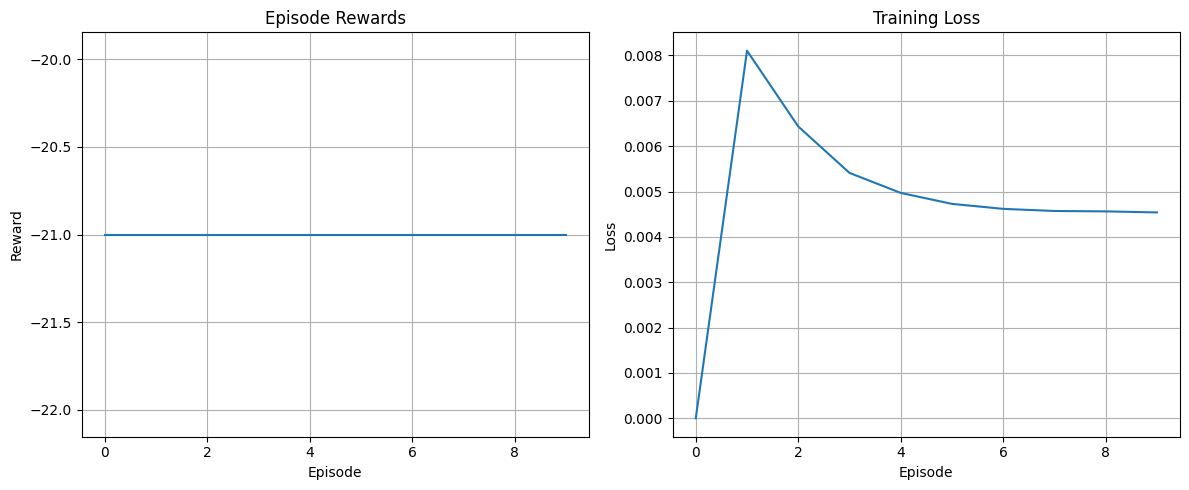

In [ ]:
rewards, losses = train_dqn(ENV_NAME, total_episodes=10, render=False, type="500_frames")

"""
This code visualizes the training progress by plotting the rewards and losses.
"""
# Plot the rewards
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

# Adding a moving average to see trends better
if len(rewards) > 10:
    moving_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')
    plt.plot(range(9, len(rewards)), moving_avg, 'r', label='10-episode moving average')
    plt.legend()

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')  # Save the figure
plt.show()

In [63]:
import gym

def evaluate_agent(env_name, model_filename, n_episodes=5, render=True, type="batch_8"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)  # Don't force remount if already mounted

    # Construct path to the model file
    model_path = f'/content/drive/MyDrive/pong_dqn_models_{type}/{model_filename}'
    print(f"Loading model from: {model_path}")
    """Evaluate a trained DQN agent."""
    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    # Load the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)
    agent.load_model(model_path)
    # Use a small epsilon for some exploration during evaluation
    agent.epsilon = 0.05

    total_rewards = []

    for episode in range(n_episodes):
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        done = False
        step = 0

        while not done:
            # Select action
            action = agent.get_action(state)

            # Execute action
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required
            if render:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}/{n_episodes}, Steps: {step}, Reward: {episode_reward}")

    # Calculate statistics
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    print(f"Evaluation Results:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Min Reward: {np.min(total_rewards)}")
    print(f"Max Reward: {np.max(total_rewards)}")

    env.close()
    return total_rewards

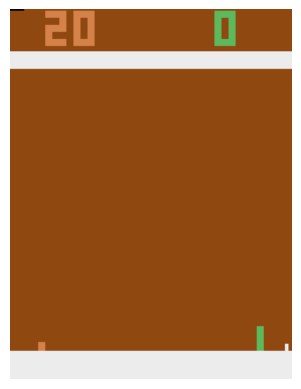

Evaluation Episode 5/5, Steps: 764, Reward: -21.0
Evaluation Results:
Average Reward: -20.80 ± 0.40
Min Reward: -21.0
Max Reward: -20.0
Average Evaluation Reward: -20.8


<Figure size 640x480 with 0 Axes>

In [ ]:
#Evaluating using saved model after 500 frames update.
evaluation_rewards = evaluate_agent(ENV_NAME, "pong_dqn_final.keras", n_episodes=5, type="500_frames")
print(f"Average Evaluation Reward: {np.mean(evaluation_rewards)}")

## **Final Network Architecture Used**

The final network architecture used is a Deep Q-Network with the following components:

Input layer accepting game frames with the specified input shape
Three convolutional layers for feature extraction:

First layer: 32 filters of size 8×8 with stride 4 and ReLU activation
Second layer: 64 filters of size 4×4 with stride 2 and ReLU activation
Third layer: 64 filters of size 3×3 with stride 1 and ReLU activation


Flatten layer to convert the 2D feature maps to a 1D vector
Fully connected layer with 512 units and ReLU activation
Output layer with linear activation producing Q-values for each possible action

## Metrics, Observations, and Parameter Analysis

##### **Batch Size 8**

- **Episode Rewards**: Shows significant fluctuations with peaks at episodes 4 and 9
- **Training Loss** : Quickly rises to ~0.005 and then stabilizes
- Average Evaluation Reward: -20.8
> The agent shows some learning, with occasional improvement in performance. 

##### **Batch Size 16**

- **Episode Rewards** : Consistently flat at -21.0 with no improvement
- **Training Loss** : Peak around 0.008 (higher than batch 8) and gradually decreases
- **Average Evaluation Reward** : -21.0
> The constant decrease in loss is promising but batch 8 performs better.


##### **Batch Size 16 with Higher Update Frequency (Lower update Window)**

- **Episode Rewards** : Oscillating pattern with higher variance and peak around -19.0
- **Loss** : Starts higher (~0.0075) and consistently decreases throughout training
- **Average Evaluation Reward** : -20.8
> Shows more exploration and potential learning than the 1000 frames update variant



#### **Impact of Parameters:**

##### **Batch Size Impact:**
- Larger batch size (16) produces higher initial loss values than smaller batch size (8)
- Batch size 8 shows better exploration and peak performance, reaching -19.0 reward
- Batch size 16 with 1000-frame updates shows no exploration or improvement in gameplay
> So lower batch sizes can be a better choice for training.


##### **Target Network Update Frequency Impact:**
- Increasing update frequency ( Lowering Update Window ) with batch size 16 significantly improves exploration
- More frequent updates (500 frames) produce a steadier, more consistent loss reduction
- More frequent updates lead to a sawtooth pattern in rewards, suggesting better exploration-exploitation balance
> So lowering the target update window is more beneficial

## **Final Section**
- Trying 100 episodes with updates every 3 episodes with batch size of 8

> Google Colab was getting disconnected approximately every 1 hour or so, therefore couldn't complete the training for more than 12~20 episodes. Below is the code to run 100 episodes with the above parameters.

In [ ]:
def train_dqn(env_name, total_episodes=20, render=True, type="batch_8"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    import os
    save_path = '/content/drive/MyDrive/pong_dqn_models_' + type
    os.makedirs(save_path, exist_ok=True)

    env = gym.make(env_name, render_mode='rgb_array')
    n_actions = env.action_space.n

    print(f"Environment: {env_name}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Action Space: {env.action_space}")

    # Initialize the agent
    agent = DQNAgent((IMAGE_SHAPE[0], IMAGE_SHAPE[1], STACK_SIZE), n_actions)

    episode_rewards = []
    episode_losses = []

    # Import numpy here, inside the function's scope
    import numpy as np

    for episode in range(total_episodes):
        # Reset environment and get initial state (old gym API)
        observation, _ = env.reset()
        frame_stacker = FrameStacker(IMAGE_SHAPE, STACK_SIZE)
        state = frame_stacker.reset(observation)

        episode_reward = 0
        episode_loss = []
        done = False
        step = 0

        # Run one episode
        while not done:
            # Select action using epsilon-greedy policy
            action = agent.get_action(state)

            # Execute action in the environment
            next_observation, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Process reward (clip to -1, 0, 1 as per standard DQN implementation)
            processed_reward = transform_reward(reward)

            # Stack frames for next state
            next_state = frame_stacker.add_frame(next_observation)

            # Store transition in replay buffer
            agent.store_transition(state, action, processed_reward, next_state, done)

            # Train agent
            loss = agent.train()
            if loss != 0:
                episode_loss.append(loss)

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            step += 1

            # Render if required (every 10 episodes to avoid slowing down training)
            if render and episode % 10 == 0:
                display.clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                display.display(plt.gcf())
                plt.clf()

        # Update target network according to update frequency
        agent.episode_count += 1
        if agent.episode_count % TARGET_UPDATE_FREQ == 0:
            agent.update_target()
            print(f"Updated target network at episode {agent.episode_count}")

        # Record metrics
        episode_rewards.append(episode_reward)
        if episode_loss:
            episode_losses.append(np.mean(episode_loss))
        else:
            episode_losses.append(0)

        # Print progress
        print(f"Episode {episode+1}/{total_episodes}, Steps: {step}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.4f}")

        # Save model every 3 episodes to Google Drive
        if (episode + 1) % 10 == 0:
            model_path = os.path.join(save_path, f"pong_dqn_episode_{episode+1}.keras")
            agent.save_model(model_path)
            print(f"Model saved at episode {episode+1} to {model_path}")

    # Save final model to Google Drive
    final_model_path = os.path.join(save_path, "pong_dqn_final.keras")
    agent.save_model(final_model_path)
    print(f"Final model saved to {final_model_path}!")

    # Also save the training metrics to Google Drive
    import numpy as np
    metrics_path = os.path.join(save_path, "training_metrics.npz")
    np.savez(metrics_path, rewards=episode_rewards, losses=episode_losses)
    print(f"Training metrics saved to {metrics_path}")

    env.close()

    return episode_rewards, episode_losses

In [ ]:
#Using Deterministic version of Pong
ENV_NAME = 'PongDeterministic-v4'
#Had to update the image size to (84,80) since encountered a shape mismatch error
IMAGE_SHAPE = (84, 80)  
#Stacking 4 frames together to reduce the training time.
STACK_SIZE = 4          

#Initial training will be run on batch size of 8, will run another round of training for 16 as well.
BATCH_SIZE = 8            


#Important Change is here. updates every 3 frames
TARGET_UPDATE_FREQ = 3   

GAMMA = 0.99 
MEMORY_SIZE = 10000         
TRAINING_START = 1000                 
EPSILON_DECAY = 0.9995       
TRAINING_START = 10000      
LEARNING_RATE = 0.00025     
EPSILON_INIT = 1.0          
EPSILON_DECAY = 0.9995      
EPSILON_MIN = 0.05    